In [31]:
from kan import *
import torch
import matplotlib.pyplot as plt
from torch import autograd
from tqdm import tqdm
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
torch.set_default_dtype(torch.float64)
dim = 2
np_i = 21 # number of interior points (along each dimension)
np_b = 21 # number of boundary points (along each dimension)
ranges = [-1, 1]
model = KAN(width=[2,2,1], grid=5, k=3, grid_eps=1.0, noise_scale_base=0.25)
def batch_jacobian(func, x, create_graph=False):
    # x in shape (Batch, Length)
    def _func_sum(x):
        return func(x).sum(dim=0)
    return autograd.functional.jacobian(_func_sum, x, create_graph=create_graph).permute(1,0,2)
# define solution
sol_fun = lambda x: torch.sin(torch.pi*x[:,[0]])*torch.sin(torch.pi*x[:,[1]]**2)
source_fun = lambda x: -torch.pi**2*(1+4*x[:,[1]]**2)*torch.sin(torch.pi*x[:,[0]])*torch.sin(torch.pi*x[:,[1]]**2)+2*torch.pi*torch.sin(torch.pi*x[:,[0]])*torch.cos(torch.pi*x[:,[1]]**2)
# interior
sampling_mode = 'random' # 'radnom' or 'mesh'

x_mesh = torch.linspace(ranges[0],ranges[1],steps=np_i)
y_mesh = torch.linspace(ranges[0],ranges[1],steps=np_i)
X, Y = torch.meshgrid(x_mesh, y_mesh, indexing="ij")
if sampling_mode == 'mesh':
    #mesh
    x_i = torch.stack([X.reshape(-1,), Y.reshape(-1,)]).permute(1,0)
else:
    #random
    x_i = torch.rand((np_i**2,2))*2-1
# boundary, 4 sides
helper = lambda X, Y: torch.stack([X.reshape(-1,), Y.reshape(-1,)]).permute(1,0)
xb1 = helper(X[0], Y[0])
xb2 = helper(X[-1], Y[0])
xb3 = helper(X[:,0], Y[:,0])
xb4 = helper(X[:,0], Y[:,-1])
x_b = torch.cat([xb1, xb2, xb3, xb4], dim=0)
steps = 50
alpha = 0.1
log = 1

def train():
    optimizer = LBFGS(model.parameters(), lr=1, history_size=10, line_search_fn="strong_wolfe", tolerance_grad=1e-32, tolerance_change=1e-32, tolerance_ys=1e-32)

    pbar = tqdm(range(steps), desc='description')

    for _ in pbar:
        def closure():
            global pde_loss, bc_loss
            optimizer.zero_grad()
            # interior loss
            sol = sol_fun(x_i)
            sol_D1_fun = lambda x: batch_jacobian(model, x, create_graph=True)[:,0,:]
            sol_D1 = sol_D1_fun(x_i)
            sol_D2 = batch_jacobian(sol_D1_fun, x_i, create_graph=True)[:,:,:]
            lap = torch.sum(torch.diagonal(sol_D2, dim1=1, dim2=2), dim=1, keepdim=True)
            source = source_fun(x_i)
            pde_loss = torch.mean((lap - source)**2)

            # boundary loss
            bc_true = sol_fun(x_b)
            bc_pred = model(x_b)
            bc_loss = torch.mean((bc_pred-bc_true)**2)

            loss = alpha * pde_loss + bc_loss
            loss.backward()
            return loss

        if _ % 5 == 0 and _ < 50:
            model.update_grid_from_samples(x_i)

        optimizer.step(closure)
        sol = sol_fun(x_i)
        loss = alpha * pde_loss + bc_loss
        l2 = torch.mean((model(x_i) - sol)**2)

        if _ % log == 0:
            pbar.set_description("pde loss: %.2e | bc loss: %.2e | l2: %.2e " % (pde_loss.cpu().detach().numpy(), bc_loss.cpu().detach().numpy(), l2.detach().numpy()))
train()

description:   0%|          | 0/50 [00:00<?, ?it/s]

pde loss: 1.28e+00 | bc loss: 1.50e-03 | l2: 1.96e-03 : 100%|██████████| 50/50 [00:21<00:00,  2.32it/s]


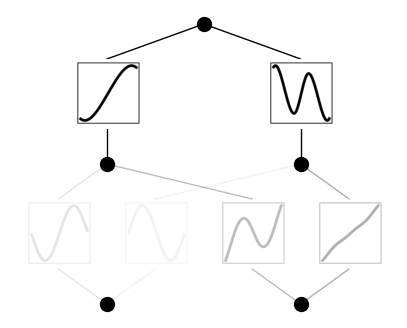

In [32]:
model.plot()

In [26]:
model.auto_symbolic()

fixing (0,0,0) with sin, r2=0.9999533856943215
fixing (0,0,1) with sin, r2=0.9999532569238785
fixing (0,1,0) with sin, r2=0.9426273928747381
fixing (0,1,1) with tan, r2=0.9996288925291557
fixing (1,0,0) with sin, r2=0.9998556810764817
fixing (1,1,0) with sin, r2=0.9015936064607747


In [27]:
train()

pde loss: 7.62e+00 | bc loss: 2.21e-01 | l2: 7.80e-02 : 100%|██████████| 20/20 [00:09<00:00,  2.19it/s]


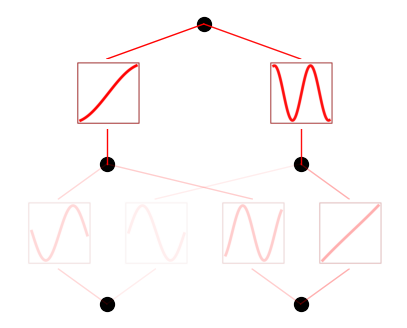

In [28]:
model.plot()

In [33]:
formula = model.symbolic_formula()[0][0]
formula

make sure all activations need to be converted to symbolic formulas first!


TypeError: 'NoneType' object is not subscriptable

/Users/lihaoyang/anaconda3/envs/pykan/lib/python3.9/site-packages/torch/functional.py:512: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/TensorShape.cpp:3588.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


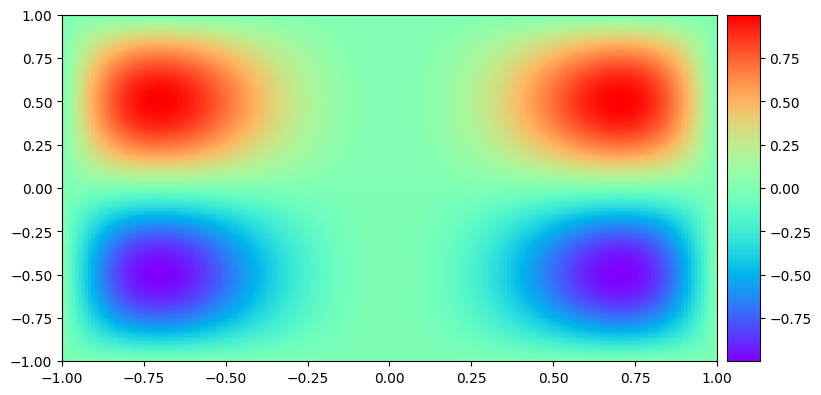

In [8]:
def plot_true():
        """ plot the solution on new data """

        import matplotlib.pyplot as plt
        from mpl_toolkits.axes_grid1 import make_axes_locatable

        x = torch.linspace(-1, 1, 200)
        t = torch.linspace(-1, 1, 200)

        # x & t grids:
        X, T = torch.meshgrid(x, t, indexing=None)

        # x & t columns:
        xcol = X.reshape(-1, 1)
        tcol = T.reshape(-1, 1)

        x_i = torch.stack([xcol.reshape(-1,), tcol.reshape(-1,)]).permute(1,0)

        # one large column:
        usol = sol_fun(x_i)

        # reshape solution:
        U = usol.reshape(x.numel(), t.numel())

        # transform to numpy:
        xnp = x.numpy()
        tnp = t.numpy()
        Unp = U.detach().numpy()

        # plot:
        fig = plt.figure(figsize=(9, 4.5))
        ax = fig.add_subplot(111)

        h = ax.imshow(Unp,
                      interpolation='nearest',
                      cmap='rainbow',
                      extent=[tnp.min(), tnp.max(), xnp.min(), xnp.max()],
                      origin='lower', aspect='auto')
        divider = make_axes_locatable(ax)
        cax = divider.append_axes("right", size="5%", pad=0.10)
        cbar = fig.colorbar(h, cax=cax)
        cbar.ax.tick_params(labelsize=10)
        plt.savefig('./poisson_true.png')
        plt.show()

plot_true()

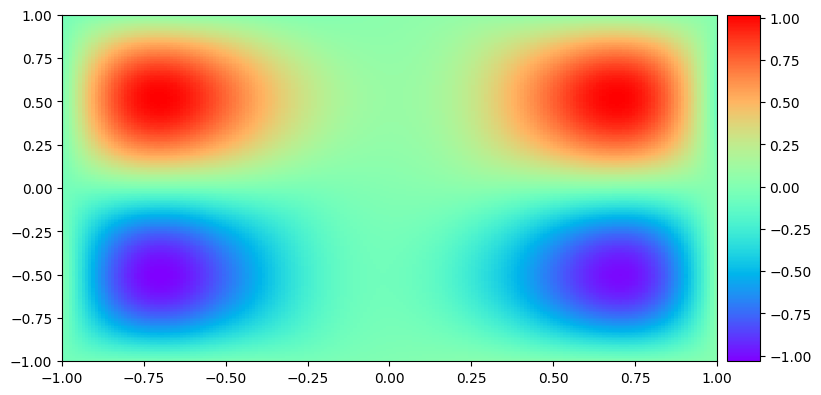

In [36]:
def plot_kan(model):
        """ plot the solution on new data """

        import matplotlib.pyplot as plt
        from mpl_toolkits.axes_grid1 import make_axes_locatable

        x = torch.linspace(-1, 1, 200)
        t = torch.linspace(-1, 1, 200)

        # x & t grids:
        X, T = torch.meshgrid(x, t, indexing=None)

        # x & t columns:
        xcol = X.reshape(-1, 1)
        tcol = T.reshape(-1, 1)

        x_i = torch.stack([xcol.reshape(-1,), tcol.reshape(-1,)]).permute(1,0)

        # one large column:
        kan_sol = model(x_i)

        # reshape solution:
        U = kan_sol.reshape(x.numel(), t.numel())

        # transform to numpy:
        xnp = x.numpy()
        tnp = t.numpy()
        Unp = U.detach().numpy()

        # plot:
        fig = plt.figure(figsize=(9, 4.5))
        ax = fig.add_subplot(111)

        h = ax.imshow(Unp,
                      interpolation='nearest',
                      cmap='rainbow',
                      extent=[tnp.min(), tnp.max(), xnp.min(), xnp.max()],
                      origin='lower', aspect='auto')
        divider = make_axes_locatable(ax)
        cax = divider.append_axes("right", size="5%", pad=0.10)
        cbar = fig.colorbar(h, cax=cax)
        cbar.ax.tick_params(labelsize=10)
        plt.savefig('./poisson_kan.png')
        plt.show()

plot_kan(model)

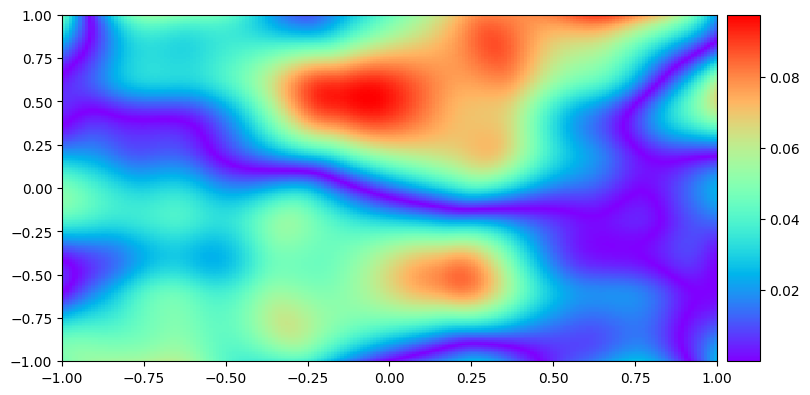

In [40]:
def plot_dif(model):
        """ plot the solution on new data """

        import matplotlib.pyplot as plt
        from mpl_toolkits.axes_grid1 import make_axes_locatable

        x = torch.linspace(-1, 1, 200)
        t = torch.linspace(-1, 1, 200)

        # x & t grids:
        X, T = torch.meshgrid(x, t, indexing=None)

        # x & t columns:
        xcol = X.reshape(-1, 1)
        tcol = T.reshape(-1, 1)

        x_i = torch.stack([xcol.reshape(-1,), tcol.reshape(-1,)]).permute(1,0)

        # one large column:
        usol = sol_fun(x_i)
        kan_sol = model(x_i)
        dif_sol = torch.abs(kan_sol - usol)

        # reshape solution:
        U = dif_sol.reshape(x.numel(), t.numel())

        # transform to numpy:
        xnp = x.numpy()
        tnp = t.numpy()
        Unp = U.detach().numpy()

        # plot:
        fig = plt.figure(figsize=(9, 4.5))
        ax = fig.add_subplot(111)

        h = ax.imshow(Unp,
                      interpolation='nearest',
                      cmap='rainbow',
                      extent=[tnp.min(), tnp.max(), xnp.min(), xnp.max()],
                      origin='lower', aspect='auto')
        divider = make_axes_locatable(ax)
        cax = divider.append_axes("right", size="5%", pad=0.10)
        cbar = fig.colorbar(h, cax=cax)
        cbar.ax.tick_params(labelsize=10)
        plt.savefig('./poisson_dif.png')
        plt.show()

plot_dif(model)